In [15]:
import pickle as pickle
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint as pp
import math as math
from matplotlib.ticker import FuncFormatter, MaxNLocator
import pandas as pd
from cosmocalc import cosmocalc
import scipy
from scipy.optimize import fsolve

import sympy
from sympy.solvers import nsolve
from sympy import Symbol

In [16]:
f=open('cal_sensitivity_data.p','rb')
cal_sigma=pickle.load(f, encoding='latin1') #dictionary with sensitivities for each frequency bin for each calibrator
f.close()

#cal_sig= np.array(list(cal_sigma.items()) #convert dictionary to array
                
N_freq=len(cal_sigma['3c84']) 
N_sources=len(cal_sigma.keys())
cal_sig_array =np.zeros([N_freq,N_sources]) 

for x,source in enumerate(cal_sigma.keys()):
    for y in range(N_freq):
        cal_sig_array[y,x]=cal_sigma[source][y]
        
    
cal_sig_array[np.where(cal_sig_array!=cal_sig_array)]=1000000.

sensitivity_threshold=np.geomspace(.1,100,31) #create sensitivity thresholds 

#binStruct= {}
#binStruct['sensitivity']=np.zeros(len(sensitivity_threshold))
#binStruct['bin_count']=np.zeros(len(sensitivity_threshold))
N_freq=len(cal_sigma['3c84'])
N_threshold=len(sensitivity_threshold)
binned_array = np.zeros(shape=(N_freq,N_threshold))

 #first loop is going thru each frequency bin    
for i in range(N_freq):
  
    #second loop is going thru each sensitivity threshold 
    for j in range(N_threshold):
       
        binned_array[i,j]=np.sum(cal_sig_array[i]*1500<=sensitivity_threshold[j]) #factor of 1500 to take into account 300 kn/s and 5 sigma detection



/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


['0.10', '0.13', '0.16', '0.20', '0.25', '0.32', '0.40', '0.50', '0.63', '0.79', '1.00', '1.26', '1.58', '2.00', '2.51', '3.16', '3.98', '5.01', '6.31', '7.94', '10.00', '12.59', '15.85', '19.95', '25.12', '31.62', '39.81', '50.12', '63.10', '79.43', '100.00']


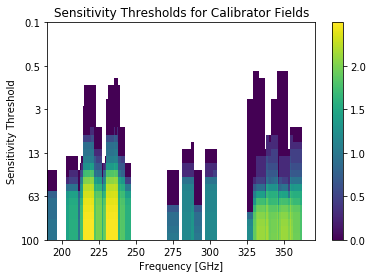

In [3]:

fig = plt.figure()
ax = fig.add_subplot(1, 1,1)
plot = ax.imshow(np.transpose(np.log10(binned_array)),extent=[190,371,100,.1],aspect='auto')

fig.colorbar(plot)
ax.set_yticklabels([.1,.5,3,13,63,100])


#plt.yscale('log')
#extent=[horizontal_min,horizontal_max,vertical_min,vertical_max].

y_label=['{:.2f}'.format(x) for x in sensitivity_threshold]
print(y_label)

#plt.xtitle('Sensitivity Thresholds')
#plt.ytitle('Frequency')
#plt.Axes.set_yticklabels('.1.003.0001')
#plt.yticks(sensitivity_threshold)
#y_label=[.1,.003,0.0001])

#plt.axes.set_yticklabels('',y_label)
#ax1.set_xticklabels
#plt.Axes.axes('Frequency [GHz]')
#plt.colorbar()
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Sensitivity Threshold')
plt.title('Sensitivity Thresholds for Calibrator Fields')

plt.savefig('SensitivityFig-fluxonly.png')
plt.show()




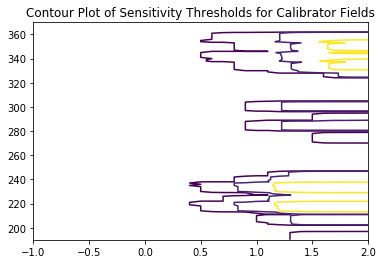

In [26]:
freq_bin=np.array(range(190,371,1))
plt.subplots(1,1)
plt.contour(np.log10(sensitivity_threshold), freq_bin,binned_array,[1,10,100])
plt.title('Contour Plot of Sensitivity Thresholds for Calibrator Fields')

plt.savefig('SensitivityContourFig-fluxonly.png')
plt.show()
#.1 is 20%, .3 is factor of 2, .5 is pi, 1 is 10

In [18]:
# Need to convert sensitivity calculations into luminosity function constraints
# Array of frequencies observed
freqObs_total=np.array(range((181)))+190
freqObs_total=freqObs_total.astype(float)
Ncal = len(cal_sig_array[0])

In [19]:
# Create function to calculate solid angle of beam [sr] to compare
def solid_angle(freqObs):
    Aper_eff = .8
    D_dish = 6 #[m]
    A_geom = (math.pi*(D_dish**2))/4
  #####  A_geom = (D_angular*math.pi/180**2)*(math.pi*/4)
    A_eff = Aper_eff*A_geom
    c = 3*10**8 #m/s
    wavelength=c/(freqObs*10**9)
    return((wavelength**2)/A_eff)
   

In [9]:

def effSolidAngle(freqObs,targetSensitivity,centerSensitivity):
    D_dish = 6. #[m]
    c = 3.E8 #m/s
    wavelength=c/(freqObs*10**9)
    FWHM = wavelength/D_dish  #radian?
   # sens = math.exp(math.log(0.5)*(2*r/FWHM)**2) #rewrite expression, solving for r
    if (targetSensitivity < centerSensitivity) or (targetSensitivity == 0):
        return(0.)
    r = (FWHM/2)*math.sqrt((math.log(centerSensitivity/targetSensitivity))/(math.log(.5)))
    if r > 1.5*(FWHM/2): #impose max
        r = 1.5*(FWHM/2)
    return((r**2)*math.pi)


In [20]:
# Create function to calculate Brightness Temp Luminosity 
def L_T(freqObs,DL, sv, z):
   
   c = 3.E8 #m/s 
   kb = 1.38E-23 #W s/K
   jy2w = 1E-26 #W Hz^-1 m^-2/Jy
   return sv*jy2w*(c**2.*np.power(freqObs*1E9,-2))*(1/(2.*kb))*np.power(DL*1E6,2)*np.power((1.+z),-3)

def S_V(freqObs,DL,LT,z):
   c = 3.E8 #m/s 
   kb = 1.38E-23 #W s/K
   jy2w = 1E-26 #W Hz^-1 m^-2/Jy
   return LT/(jy2w*(c**2.*np.power(freqObs*1E9,-2))*(1/(2.*kb))*np.power(DL*1E6,2)*np.power((1.+z),-3))


# Create function to calculate Brightness Temp Luminosity in observer units [K km s^-1 pc^2]
#(A18, Obreschkow et al 2009)

def L_T_obsunits(freqObs,DL, sv, z):
   
   c = 3.E8 #km/s 
   kb = 1.38E-23 #
   return (3.255E7)*np.power(freqObs*1E9,-2)*np.power(DL,2)*np.power((1.+z),-3)*sv

In [10]:
#CALCULATE EFFECTIVE AREA PROBED
target_sensitivity=np.geomspace(.1,100,61) #Jy
total_area_per_freq = np.zeros([N_freq,len(target_sensitivity)],dtype=np.float)

#first loop is going thru each frequency bin 
for i in range(N_freq):
  
    #second loop is going thru each sensitivity threshold 
    for j in range(len(target_sensitivity)):
        EffArea_sum=0. #reset for each loop over target sensitivity
        for k in range(Ncal):
    
                #sum over cal
            if cal_sig_array[i,k] != 0.:
                EffArea_sum+=effSolidAngle(freqObs_total[i],target_sensitivity[j],cal_sig_array[i,k]*300.*5.)
                   
        total_area_per_freq[i,j]=EffArea_sum
        
        

In [124]:
#For each spectral line for each freq for each target brightness bin --> calculate the volume of space probed
#n_lines is the # of spectral lines 
#n_zbin is the # of redshift bins 
line_rest_freqs = np.array([345E9,1896E9,345E9,461E9,576E9]) #CII, CO32, CO43, CO54 ,345E9,461E9,576E9
n_lines = len(line_rest_freqs)
n_zbin = 3
n_lumbin = 61
line_sensitivity_vs_vol = np.zeros([n_lines,n_zbin,n_lumbin])
target_luminosity=np.geomspace(1E8,1E12,61)
#target_luminosity_2=np.geomspace(1E8,1E12,40)
#print(np.log10(target_luminosity_2))

for i in range(n_lines):
    restFreq = line_rest_freqs[i]
    for j in range(N_freq):
        obsFreq = freqObs_total[j]*1E9
        obsStart = (freqObs_total[j]-0.5)*1E9
        obsEnd = (freqObs_total[j]+0.5)*1E9
        zRed=(restFreq/obsFreq)-1
        cosmoVals = cosmocalc(zRed)
        comoving_rad_dist = cosmoVals['DL_Mpc']
        comoving_delta_rad = cosmocalc((restFreq/obsStart)-1)['DL_Mpc']-cosmocalc((restFreq/obsEnd)-1)['DL_Mpc']
        if obsFreq < 250E9:
            zIdx = 0
        elif obsFreq < 315E9:
            zIdx = 1
        else:
            zIdx = 2
        #print(i,j,l)
        for k in range(n_lumbin):
            lineLum = target_luminosity[k]
            lineFlux = S_V(obsFreq/1E9,comoving_rad_dist*(1+zRed),lineLum,zRed)
            for l in range(Ncal):
                sigmaThresh = 5.
                lineWidth = 300.
                if zRed>0:
                    calVol = effSolidAngle(obsFreq/1E9,lineFlux,cal_sig_array[j,l]*sigmaThresh*lineWidth)*np.power(comoving_rad_dist,2)*comoving_delta_rad
                
                    line_sensitivity_vs_vol[i,zIdx,k]+=calVol
                
             
                    
                
#repeat plot for each of the spectral lines
#repeat plots for each redshift bin               
#guesstimate based on volume how many objects we may see (check out Decarli)


[  8.           8.1025641    8.20512821   8.30769231   8.41025641
   8.51282051   8.61538462   8.71794872   8.82051282   8.92307692
   9.02564103   9.12820513   9.23076923   9.33333333   9.43589744
   9.53846154   9.64102564   9.74358974   9.84615385   9.94871795
  10.05128205  10.15384615  10.25641026  10.35897436  10.46153846
  10.56410256  10.66666667  10.76923077  10.87179487  10.97435897
  11.07692308  11.17948718  11.28205128  11.38461538  11.48717949
  11.58974359  11.69230769  11.79487179  11.8974359   12.        ]


/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


0.0


1000000.0


/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log10
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log10
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log10
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divi

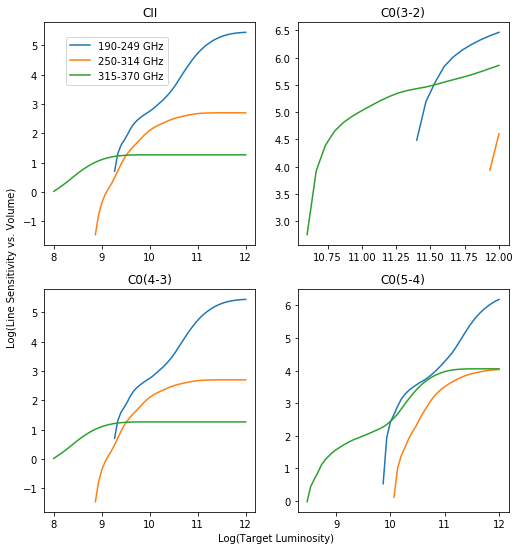

In [125]:


'''
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')'''

fig = plt.figure()
ax = fig.add_subplot(111)    # dimensions of subplot
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
#f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharex=True, sharey=True)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')




#fig.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)


#fig.legend((l1, l2), ('Line 1', 'Line 2'), 'upper left')
#fig.legend((l3, l4), ('Line 3', 'Line 4'), 'upper right')


ax1.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[0,0,:]),label='190-249 GHz')
ax1.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[0,1,:]),label='250-314 GHz')
ax1.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[0,2,:]),label='315-370 GHz')
#ax1.xlabel('Log(Target Luminosity)')
#ax1.ylabel('Log(Line Sensitivity vs. Volume)')
ax1.set_title('CII')
#ax.legend()
#ax.show()




ax2.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[1,0,:]),label='190-249 GHz')
ax2.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[1,1,:]),label='250-314 GHz')
ax2.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[1,2,:]),label='315-370 GHz')
#plt.xlabel('Log(Target Luminosity)')
#plt.ylabel('Log(Line Sensitivity vs. Volume)')
ax2.set_title('C0(3-2)')

#ax.show1.8
plt.subplots_adjust(bottom=0.1, right=1.2, top=1.8)



ax3.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[2,0,:]),label='190-249 GHz')
ax3.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[2,1,:]),label='250-314 GHz')
ax3.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[2,2,:]),label='315-370 GHz')
#ax3xlabel('Log(Target Luminosity)')
#ax3ylabel('Log(Line Sensitivity vs. Volume)')
ax3.set_title('C0(4-3)')
#ax.legend()
#ax.show()

ax4.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[3,0,:]),label='190-249 GHz')
ax4.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[3,1,:]),label='250-314 GHz')
ax4.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[3,2,:]),label='315-370 GHz')
#plt.xlabel('Log(Target Luminosity)')
#plt.ylabel('Log(Line Sensitivity vs. Volume)')
ax4.set_title('C0(5-4)')
#ax.legend()
#ax.show()


#ax = fig.add_subplot(1, 1,1)
ax.set_xlabel('Log(Target Luminosity)')
ax.set_ylabel('Log(Line Sensitivity vs. Volume)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',bbox_to_anchor=(.4, 1.8))

plt.savefig('TargetLum-vs-LineSensitivity.png',bbox_inches="tight")
plt.show()

/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log10
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log10
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log10
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divi

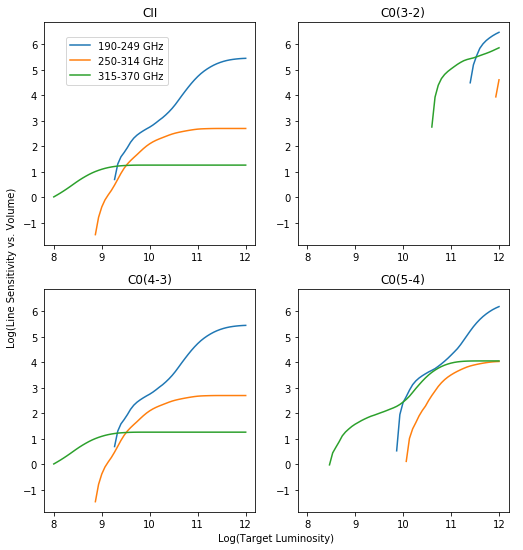

In [130]:


'''
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')'''

fig = plt.figure()
ax = fig.add_subplot(111)    # dimensions of subplot
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(223, sharex=ax1, sharey=ax1)
ax4 = fig.add_subplot(224, sharex=ax1, sharey=ax1)
#f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharex=True, sharey=True)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')




#fig.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)


#fig.legend((l1, l2), ('Line 1', 'Line 2'), 'upper left')
#fig.legend((l3, l4), ('Line 3', 'Line 4'), 'upper right')


ax1.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[0,0,:]),label='190-249 GHz')
ax1.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[0,1,:]),label='250-314 GHz')
ax1.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[0,2,:]),label='315-370 GHz')
#ax1.xlabel('Log(Target Luminosity)')
#ax1.ylabel('Log(Line Sensitivity vs. Volume)')
ax1.set_title('CII')
#ax.legend()
#ax.show()




ax2.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[1,0,:]),label='190-249 GHz')
ax2.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[1,1,:]),label='250-314 GHz')
ax2.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[1,2,:]),label='315-370 GHz')
#plt.xlabel('Log(Target Luminosity)')
#plt.ylabel('Log(Line Sensitivity vs. Volume)')
ax2.set_title('C0(3-2)')

#ax.show1.8
plt.subplots_adjust(bottom=0.1, right=1.2, top=1.8)



ax3.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[2,0,:]),label='190-249 GHz')
ax3.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[2,1,:]),label='250-314 GHz')
ax3.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[2,2,:]),label='315-370 GHz')
#ax3xlabel('Log(Target Luminosity)')
#ax3ylabel('Log(Line Sensitivity vs. Volume)')
ax3.set_title('C0(4-3)')
#ax.legend()
#ax.show()

ax4.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[3,0,:]),label='190-249 GHz')
ax4.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[3,1,:]),label='250-314 GHz')
ax4.plot(np.log10(target_luminosity),np.log10(line_sensitivity_vs_vol[3,2,:]),label='315-370 GHz')
#plt.xlabel('Log(Target Luminosity)')
#plt.ylabel('Log(Line Sensitivity vs. Volume)')
ax4.set_title('C0(5-4)')
#ax.legend()
#ax.show()


#ax = fig.add_subplot(1, 1,1)
ax.set_xlabel('Log(Target Luminosity)')
ax.set_ylabel('Log(Line Sensitivity vs. Volume)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',bbox_to_anchor=(.4, 1.8))

plt.savefig('TargetLum-vs-LineSensitivity-sharedaxes.png',bbox_inches="tight")
plt.show()

/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipyk

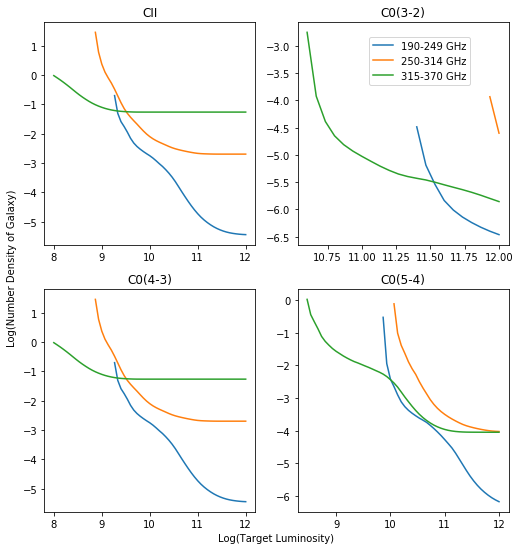

In [128]:


'''
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')'''

fig = plt.figure()
ax = fig.add_subplot(111)    # dimensions of subplot
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
#f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharex=True, sharey=True)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')




#fig.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)


#fig.legend((l1, l2), ('Line 1', 'Line 2'), 'upper left')
#fig.legend((l3, l4), ('Line 3', 'Line 4'), 'upper right')


ax1.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[0,0,:]),label='190-249 GHz')
ax1.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[0,1,:]),label='250-314 GHz')
ax1.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[0,2,:]),label='315-370 GHz')
#ax1.xlabel('Log(Target Luminosity)')
#ax1.ylabel('Log(Line Sensitivity vs. Volume)')
ax1.set_title('CII')
#ax.legend()
#ax.show()




ax2.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[1,0,:]),label='190-249 GHz')
ax2.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[1,1,:]),label='250-314 GHz')
ax2.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[1,2,:]),label='315-370 GHz')
#plt.xlabel('Log(Target Luminosity)')
#plt.ylabel('Log(Line Sensitivity vs. Volume)')
ax2.set_title('C0(3-2)')

#ax.show1.8
plt.subplots_adjust(bottom=0.1, right=1.2, top=1.8)



ax3.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[2,0,:]),label='190-249 GHz')
ax3.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[2,1,:]),label='250-314 GHz')
ax3.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[2,2,:]),label='315-370 GHz')
#ax3xlabel('Log(Target Luminosity)')
#ax3ylabel('Log(Line Sensitivity vs. Volume)')
ax3.set_title('C0(4-3)')
#ax.legend()
#ax.show()

ax4.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[3,0,:]),label='190-249 GHz')
ax4.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[3,1,:]),label='250-314 GHz')
ax4.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[3,2,:]),label='315-370 GHz')
#plt.xlabel('Log(Target Luminosity)')
#plt.ylabel('Log(Line Sensitivity vs. Volume)')
ax4.set_title('C0(5-4)')
#ax.legend()
#ax.show()


#ax = fig.add_subplot(1, 1,1)
ax.set_xlabel('Log(Target Luminosity)')
ax.set_ylabel('Log(Number Density of Galaxy)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',bbox_to_anchor=(1.1, 1.8))

plt.savefig('TargetLum-vs-NumberDensity.png',bbox_inches="tight")
plt.show()

/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/Users/mfuchs/anaconda/lib/python3.6/site-packages/ipyk

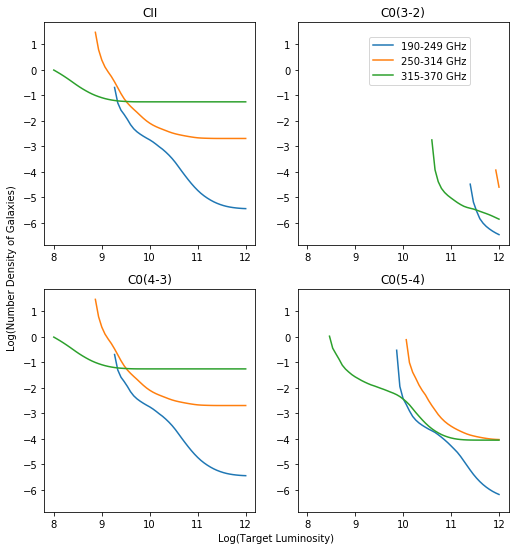

In [127]:


'''
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')'''

fig = plt.figure()
ax = fig.add_subplot(111)    # dimensions of subplot
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(223, sharex=ax1, sharey=ax1)
ax4 = fig.add_subplot(224, sharex=ax1, sharey=ax1)
#f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharex=True, sharey=True)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')




#fig.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)


#fig.legend((l1, l2), ('Line 1', 'Line 2'), 'upper left')
#fig.legend((l3, l4), ('Line 3', 'Line 4'), 'upper right')


ax1.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[0,0,:]),label='190-249 GHz')
ax1.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[0,1,:]),label='250-314 GHz')
ax1.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[0,2,:]),label='315-370 GHz')
#ax1.xlabel('Log(Target Luminosity)')
#ax1.ylabel('Log(Line Sensitivity vs. Volume)')
ax1.set_title('CII')
#ax.legend()
#ax.show()




ax2.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[1,0,:]),label='190-249 GHz')
ax2.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[1,1,:]),label='250-314 GHz')
ax2.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[1,2,:]),label='315-370 GHz')
#plt.xlabel('Log(Target Luminosity)')
#plt.ylabel('Log(Line Sensitivity vs. Volume)')
ax2.set_title('C0(3-2)')

#ax.show1.8
plt.subplots_adjust(bottom=0.1, right=1.2, top=1.8)



ax3.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[2,0,:]),label='190-249 GHz')
ax3.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[2,1,:]),label='250-314 GHz')
ax3.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[2,2,:]),label='315-370 GHz')
#ax3xlabel('Log(Target Luminosity)')
#ax3ylabel('Log(Line Sensitivity vs. Volume)')
ax3.set_title('C0(4-3)')
#ax.legend()
#ax.show()

ax4.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[3,0,:]),label='190-249 GHz')
ax4.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[3,1,:]),label='250-314 GHz')
ax4.plot(np.log10(target_luminosity),np.log10(1/line_sensitivity_vs_vol[3,2,:]),label='315-370 GHz')
#plt.xlabel('Log(Target Luminosity)')
#plt.ylabel('Log(Line Sensitivity vs. Volume)')
ax4.set_title('C0(5-4)')
#ax.legend()
#ax.show()


#ax = fig.add_subplot(1, 1,1)
ax.set_xlabel('Log(Target Luminosity)')
ax.set_ylabel('Log(Number Density of Galaxies)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',bbox_to_anchor=(1.1, 1.8))

plt.savefig('TargetLum-vs-NumberDensity-sharedaxes.png',bbox_inches="tight")
plt.show()